In [3]:
# The following code is from Zhaoyi Zhang.
# I tested it to see if it works for trees with 4 taxa
from math import comb
from itertools import combinations, islice
import time

from Bio import Phylo
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 12

In [4]:
# In the data provided by Marianne, the names of the taxa are replaced with integers
trees = Phylo.parse('data/4taxa_trees.tre', 'newick')
next(trees)
tree = next(trees)

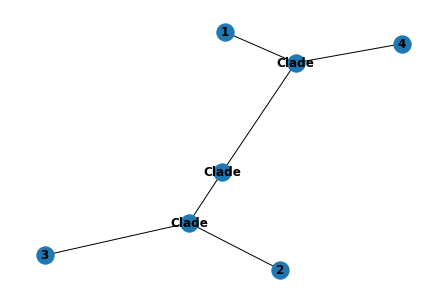

In [5]:
import networkx as nx
G = Phylo.to_networkx(tree)
nx.draw(G, with_labels=True, font_weight='bold')

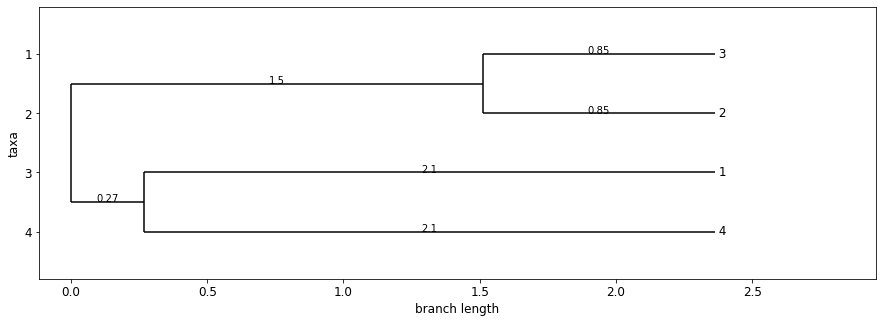

In [6]:
def format_branch_length(node):
    if node.branch_length:
        return f'{node.branch_length:.2}'
    else:
        return ''

fig, ax = plt.subplots(figsize=(15, 5))
Phylo.draw(tree, branch_labels=format_branch_length, axes=ax)

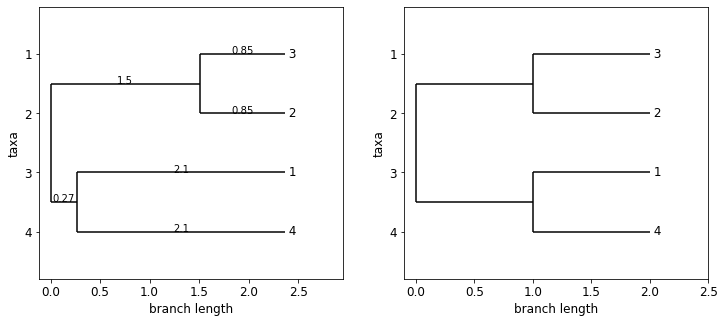

In [7]:
# figures for debugging
def clear_branch_length(clade):
    if clade.clades:
        for c in clade.clades:
            c.branch_length = 1
            clear_branch_length(c)

def draw_equal_branch_length(tree, axes=None):
    t = Phylo.BaseTree.Tree.from_clade(tree.clade)
    clear_branch_length(t.clade)
    Phylo.draw(t, axes=axes)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
Phylo.draw(tree, axes=ax0, do_show=False, branch_labels=format_branch_length)
draw_equal_branch_length(tree, ax1)

In [8]:
def get_direct_children(clade, res=None):
    '''
    get direct children of each clade
    '''
    if res == None:
        res = {}
    res[clade] = []
    if len(clade.clades) == 0:
        return
    for c in clade.clades:
        res[clade].append(c)
        get_direct_children(c, res)
    return res

def expand_direct_children(res):
    '''
    expand direct children of each clade into descendants
    '''
    res_expand = {}
    for k, v in reversed(res.items()):
        res_expand[k] = []
        for c in v:
            if c.name and str.isdigit(c.name):
                res_expand[k].append(c)
            else:
                res_expand[k].extend(res_expand[c])
    return res_expand

def get_descendants(clade):
    '''
    get descendants of each clade in the `clade`
    '''
    res = get_direct_children(clade)
    return expand_direct_children(res)

def print_children(res):
    def get_name_or_length(c):
        return c.name or (c.branch_length and f'{c.branch_length:.2}')
    for k, v in res.items():
        print(get_name_or_length(k), '\t',
              list(map(lambda c: get_name_or_length(c), v)))
        
def desc_to_length(descendants):
    res = []
    for parent, desc in descendants.items():
        if desc:
            res.append(([d.name for d in desc], parent.branch_length))
        else:
            res.append((parent.name, parent.branch_length))
    return res

In [9]:
children = get_direct_children(tree.clade)
print_children(children)

None 	 ['1.5', '0.27']
1.5 	 ['3', '2']
3 	 []
2 	 []
0.27 	 ['1', '4']
1 	 []
4 	 []


In [10]:
descendants = get_descendants(tree.clade)
print_children(descendants)

4 	 []
1 	 []
0.27 	 ['1', '4']
2 	 []
3 	 []
1.5 	 ['3', '2']
None 	 ['3', '2', '1', '4']


In [11]:
desc_to_length(descendants)

[('4', 2.093894),
 ('1', 2.093894),
 (['1', '4'], 0.269101),
 ('2', 0.852455),
 ('3', 0.852455),
 (['3', '2'], 1.51054),
 (['3', '2', '1', '4'], None)]

$$
\begin{align}
2^{n} &= \sum_{i=0}^{n} \binom{n}{i} \\
bipartitions &= \frac{1}{2} \sum_{i=1}^{n-1} \binom{n}{i} \\
&= \frac{1}{2} \left(\sum_{i=0}^{n}{\binom{n}{i}} - \binom{n}{0} - \binom{n}{n}\right) \\
&= \frac{1}{2} \left(2^{n} - 2\right) \\
&= 2^{n-1} - 1
\end{align}
$$

In [12]:
for n in range(1, 100):
    assert sum(comb(n, i) for i in range(1, n)) // 2 == 2**(n-1) - 1

In [13]:
def num_bipartitions(n):
    '''
    summing from C(n, 1) to C(n, n-1) and divided by 2
    C(n, 1) is a|bc..n, b|ac..n, n|ab..m
    C(n, n-1) is bc..n|a, ac..n|b, ab..m|n
    C(n, 0) and C(n, n) are not possible
    '''
    return 2**(n-1) - 1

def show_bipartitions(n, show_section=False, start=0, end=None):
    idx_width = len(str(num_bipartitions(n)))
    node_width = len(str(n))
    idx = 0
    u = set(range(1, n + 1))
    print('idx\tpartition')
    for i in range(1, n//2+1):
        if show_section:
            print(f'{i}/{n-i}')
            
        iterable = combinations(range(1, n + 1), i)
        if i == n - i:
            iterable = islice(iterable, comb(n, i) // 2)
            
        for l in iterable:
            if start <= idx and (end == None or idx <= end):
                print(f'{idx:{idx_width}}', end='\t')
                for e in l:
                    print(f'{e:{node_width}}', end=' ')
                print('|', end=' ')
                for e in u - set(l):
                    print(f'{e:{node_width}}', end=' ')
                print()
            idx += 1

def show_bipartition(n, idx):
    show_bipartitions(n, start=idx, end=idx)

show_bipartitions(4)
show_bipartition(4, idx=5)

idx	partition
0	1 | 2 3 4 
1	2 | 1 3 4 
2	3 | 1 2 4 
3	4 | 1 2 3 
4	1 2 | 3 4 
5	1 3 | 2 4 
6	1 4 | 2 3 
idx	partition
5	1 3 | 2 4 


In [14]:
class BipartitionEnc():
    def __init__(self, n):
        self.n = n
        self.b = num_bipartitions(n)
        
        self.idx_offset = {}
        self.idx_offset[1] = 0
        for i in range(2, n + 1):
            self.idx_offset[i] = comb(n, i - 1) + self.idx_offset[i - 1]
            
        self.u = set(range(1, n + 1))

    def _rank(self, desc):
        k = len(desc)
        rank = comb(self.n, k)
        for i, d in enumerate(sorted(desc)):
            rank -= comb(self.n - d, k - i)
        return rank

    def get_idx_from_desc(self, desc):
        desc = [int(d) for d in desc]
        if len(desc) > self.n//2:
            desc = self.u - set(desc)
        offset = self.idx_offset[len(desc)]
        rk = self._rank(desc) + offset - 1
        if rk >= self.b:
            rk = 2 * self.b - 1 - rk
        return rk
    
    def encode(self, tree, return_desc=False):
        t_nodes = tree.get_terminals()
        if len(t_nodes) != self.n:
            raise Exception(f'Expected {self.n} terminal nodes, but the tree has {len(t_nodes)}')
        encoding = []
        descendants = get_descendants(tree.clade)
        res = desc_to_length(descendants)
        for desc, branch_length in res:
            if len(desc) != self.n:
                idx = self.get_idx_from_desc(desc)
                if return_desc:
                    encoding.append((desc, idx, branch_length))
                else:
                    encoding.append((idx, branch_length))
        return encoding

In [15]:
be = BipartitionEnc(4)
be.encode(tree)

[(3, 2.093894),
 (0, 2.093894),
 (6, 0.269101),
 (1, 0.852455),
 (2, 0.852455),
 (6, 1.51054)]

In [18]:
# do not use below two methods
# a) print pairs in 2D array
def printPairs(trees):
    data = []
    # record the tree number
    treeNum = 1;
    for i in trees:
        tree = be.encode(i)
        data.append(tree)
        treeNum += 1
    return data

# same as b but with title
def printBipartIdxTitle(trees,n): 
    # build the table
    data = []
    N = num_bipartitions(n)
    treeNum = 1;
    # get existing index
    Idx = []
    length = []
    
    for i in trees:
        col = []
        for j in range(N * 2):
            col.append(0)
        col.insert(0,"Tree" + str(treeNum))
        data.append(col)
        treeNum += 1
        tree = be.encode(i)
        # record index and length in a single tree
        treeIdx = []
        treeLen = []
        for j in range(len(tree)):
            treeIdx.append(tree[j][0])
            treeLen.append(tree[j][1])
        Idx.append(treeIdx)
        length.append(treeLen)

    # insert branch length to corresponding idx
    for i in range(len(Idx)):
        for j in range(len(Idx[i])):
            if data[i][Idx[i][j] + 1] == 0:
                data[i][Idx[i][j] + 1] = length[i][j]
            else: # if the index is duplicated, the length is inserted in the second index.
                data[i][Idx[i][j] + 8] = length[i][j]
   
    
    
     # generate the index
    title = ["Name"]
    for i in range(N):
        title.append(i)
    for i in range(N):
        title.append(i)
    data.insert(0,title)
    return data


In [19]:
# print data into a csv file

def printFile(data, filePath = 'data/test.csv'):
    f = open(filePath, 'w')
    for i in data:
        # from https://stackoverflow.com/questions/11178061/print-list-without-brackets-in-a-single-row
        print(', '.join(map(str,i)), file = f)

In [20]:
test = [tree, next(trees), next(trees), next(trees)]
result = printPairs(test)
for i in result:
    print(i)
printFile(result)

[(3, 2.093894), (0, 2.093894), (6, 0.269101), (1, 0.852455), (2, 0.852455), (6, 1.51054)]
[(0, 1.416471), (1, 0.869023), (2, 0.869023), (6, 0.547448), (3, 1.245908), (3, 2.662378)]
[(0, 1.477797), (1, 1.165187), (2, 1.165187), (6, 0.312611), (3, 1.723904), (3, 3.201701)]
[(3, 2.190102), (1, 1.085772), (0, 0.774945), (2, 0.774945), (5, 0.310827), (3, 1.10433)]


In [21]:
# b) print the bipartition names and the corresponding branch lengths in each tree
def printBipartIdx(trees,n): 
    # build the table
    data = []
    N = num_bipartitions(n)
    treeNum = 1;
    # get existing index
    Idx = []
    length = []
    
    for i in trees:
        col = []
        for j in range(N):
            col.append(0)
        data.append(col)
        treeNum += 1
        tree = be.encode(i)
        # record index and length in a single tree
        treeIdx = []
        treeLen = []
        for j in range(len(tree)):
            treeIdx.append(tree[j][0])
            treeLen.append(tree[j][1])
        Idx.append(treeIdx)
        length.append(treeLen)

    # insert branch length to corresponding idx
    for i in range(len(Idx)):
        for j in range(len(Idx[i])):
            data[i][Idx[i][j]] += length[i][j]
    
    # generate index
    title = []
    for i in range(N):
        title.append(i)
    data.insert(0,title)
    
    return data


In [22]:
test = [tree, next(trees), next(trees), next(trees)]
result = printBipartIdx(test,4)
for i in result:
    print(i)
printFile(result)

[0, 1, 2, 3, 4, 5, 6]
[2.093894, 0.852455, 0.852455, 2.093894, 0, 0, 1.779641]
[1.45132, 2.462908, 1.45132, 2.61668, 0, 1.011588, 0]
[0.780537, 2.267903, 0.780537, 2.267903, 0, 3.558166, 0]
[0.559148, 1.34381, 0.559148, 8.129684000000001, 0, 0.784662, 0]


In [23]:
# print trees in both ways
trees = Phylo.parse('data/4taxa_trees.tre', 'newick')
treeList = []
for tree in trees:
    treeList.append(tree)
    
# print use a method
#result = printPairs(treeList)
#printFile(result,"data/pair_4taxa_tree.csv")

# print use b method
result = printBipartIdx(treeList,4)
printFile(result,"data/bipartition_4taxa_tree.csv")